In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Multiclassification en utilisant le modèle Gradient Boosting avec les hyperparamètres trouvés pour la bi classifiaction

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Load the dataset
machines_data = pd.read_csv('predictive_maintenance.csv')

# Define features and target
num_features = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
cat_features = ["Type"]
target_variable = 'Failure Type'  # The new target for multiclass classification
not_imp_variables = ['UDI', 'Product ID','Target']

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Split the data into training and testing sets
train_df, test_df = train_test_split(machines_data, test_size=0.2, random_state=42)

# Separate input features and target variable
input_features_train_df = train_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_train_df = train_df[target_variable]

input_features_test_df = test_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_test_df = test_df[target_variable]

# Encode the target variable ('Failure Type') into integers using LabelEncoder
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train_df)
target_test_encoded = label_encoder.transform(target_test_df)

# Preprocess the input features
input_features_train_df_array = preprocessor.fit_transform(input_features_train_df)
input_features_test_df_array = preprocessor.transform(input_features_test_df)

# Combine input features and target variable into arrays
train_array = np.c_[input_features_train_df_array, target_train_encoded]
test_array = np.c_[input_features_test_df_array, target_test_encoded]

# Define X and y for training and testing
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

# Initialize the Gradient Boosting Classifier with tuned hyperparameters
gradient_boosting_best_model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=9,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=173,
    subsample=0.9,
    random_state=42
)

# Train the model on the training set
gradient_boosting_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting_best_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score for multiclass
print(f"F1 Score on Test Set (Weighted): {f1}")

# Generate the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


F1 Score on Test Set (Weighted): 0.977817015890011
Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.88      0.93      0.90        15
              No Failure       0.99      0.99      0.99      1935
      Overstrain Failure       0.75      0.69      0.72        13
           Power Failure       0.76      0.80      0.78        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.20      0.18      0.19        11

                accuracy                           0.98      2000
               macro avg       0.60      0.60      0.60      2000
            weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[  14    1    0    0    0    0]
 [   1 1917    2    5    2    8]
 [   0    4    9    0    0    0]
 [   0    3    1   16    0    0]
 [   0    6    0    0    0    0]
 [   1    8    0    0    0    2]]


In [4]:
import joblib

# Save the Gradient Boosting model
joblib.dump(gradient_boosting_best_model, "gradient_boosting_model.pkl")

# Save the LabelEncoder
joblib.dump(label_encoder, "label_encoder.pkl")

# Save the preprocessing pipeline
joblib.dump(preprocessor, "preprocessor.pkl")

print("Model, LabelEncoder, and Preprocessor saved successfully.")


Model, LabelEncoder, and Preprocessor saved successfully.


In [4]:
input_features_train_df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
9254,L,298.3,309.1,1616,31.1,195
1561,L,298.2,308.4,1388,53.8,137
1670,L,298.2,307.8,1528,31.1,194
6087,M,300.9,310.8,1599,33.0,7
6669,L,301.4,310.5,1571,33.9,208
...,...,...,...,...,...,...
5734,L,302.3,311.8,1369,56.2,208
5191,L,304.0,313.2,1416,46.0,128
5390,H,302.8,312.3,1483,47.2,223
860,H,296.1,306.9,1541,32.6,33


In [5]:
target_test_df

6252       No Failure
4684       No Failure
1731       No Failure
4742       No Failure
4521       No Failure
            ...      
6412       No Failure
8285       No Failure
7853       No Failure
1095    Power Failure
6929       No Failure
Name: Failure Type, Length: 2000, dtype: object

In [6]:
y_pred

array([1., 1., 1., ..., 1., 3., 1.])

In [16]:
# function to create confusion matrix
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    make_scorer,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Function to create confusion matrix for multiclass classification
def make_confusion_matrix(model, X_test, y_actual, class_names):
    """
    Generate a confusion matrix heatmap for multiclass classification.
    
    Parameters:
    model : Trained classifier to predict values of X_test
    X_test : Input features of test data
    y_actual : Ground truth labels
    class_names : List of class names for labeling the confusion matrix
    """
    # Predict on test set
    y_predict = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_actual, y_predict)
    
    # Convert confusion matrix into a DataFrame for better readability
    df_cm = pd.DataFrame(
        cm, 
        index=[f"Actual - {label}" for label in class_names], 
        columns=[f"Predicted - {label}" for label in class_names]
    )
    
    # Annotate confusion matrix with counts and percentages
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(class_names), len(class_names))
    
    # Plot the confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


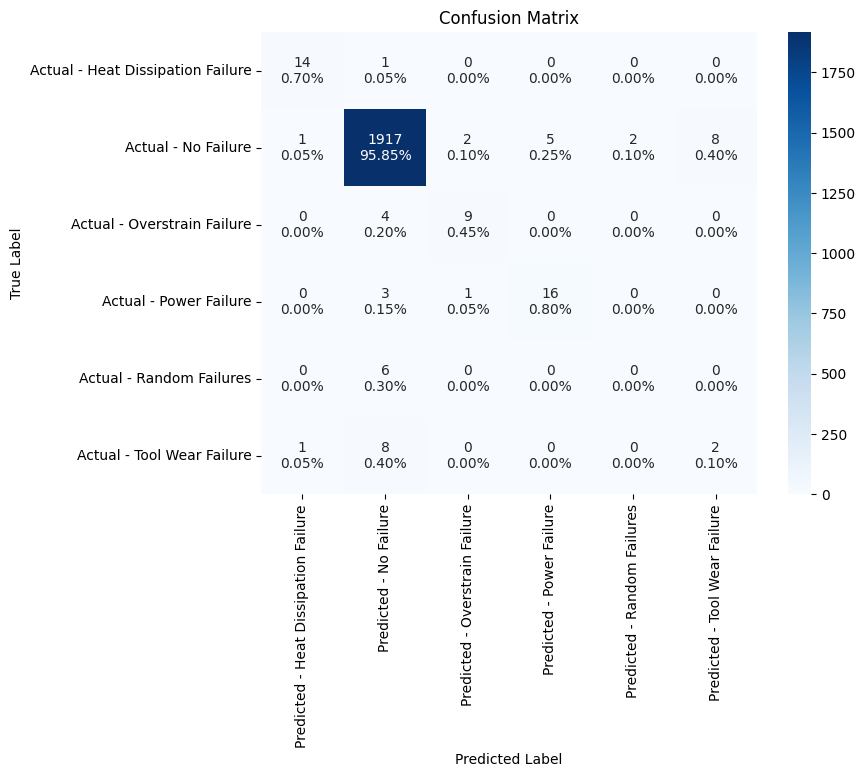

In [18]:
# Call the function to plot the confusion matrix
make_confusion_matrix(
    model=gradient_boosting_best_model,   # Trained Gradient Boosting model
    X_test=X_test,                       # Test features
    y_actual=y_test,                     # True test labels
    class_names=label_encoder.classes_   # Class names (from LabelEncoder)
)


# Multiclassification en utilisant le modèle Gradient Boosting avec Randomized Search CV pour trouver les meilleurs hyperparamètres

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE  # Import SMOTE
from scipy.stats import randint, uniform

# Load the dataset
machines_data = pd.read_csv('predictive_maintenance.csv')

# Define features and target
num_features = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
cat_features = ["Type"]
target_variable = 'Failure Type'  # The target for multiclass classification
not_imp_variables = ['UDI', 'Product ID', 'Target']

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Split the data into training and testing sets
train_df, test_df = train_test_split(machines_data, test_size=0.2, random_state=42)

# Separate input features and target variable
input_features_train_df = train_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_train_df = train_df[target_variable]

input_features_test_df = test_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_test_df = test_df[target_variable]

# Encode the target variable ('Failure Type') into integers using LabelEncoder
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train_df)
target_test_encoded = label_encoder.transform(target_test_df)

# Preprocess the input features
input_features_train_df_array = preprocessor.fit_transform(input_features_train_df)
input_features_test_df_array = preprocessor.transform(input_features_test_df)

# Combine input features and target variable into arrays
train_array = np.c_[input_features_train_df_array, target_train_encoded]
test_array = np.c_[input_features_test_df_array, target_test_encoded]

# Define X and y for training and testing
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

In [2]:
# Step 1: Apply SMOTE to oversample the minority classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training dataset shape: {np.bincount(y_train.astype(int))}")
print(f"Resampled training dataset shape: {np.bincount(y_train_resampled.astype(int))}")

C:\Users\Zahra\Desktop\ProjectBigDataAnalytics\venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Zahra\Desktop\ProjectBigDataAnalytics\venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training dataset shape: [  97 7717   65   75   12   34]
Resampled training dataset shape: [7717 7717 7717 7717 7717 7717]


In [3]:
# Step 2: Initialize the Gradient Boosting Classifier
base_model = GradientBoostingClassifier(random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),            # Number of boosting stages (trees)
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size for each boosting step
    'max_depth': randint(3, 10),                  # Maximum depth of each tree
    'min_samples_split': randint(2, 20),          # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10),           # Minimum samples required at a leaf node
    'subsample': [0.7, 0.8, 0.9, 1.0]        # Fraction of samples used for fitting trees
}

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1_weighted',  # Evaluation metric (weighted F1-score for multiclass)
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Step 4: Perform RandomizedSearchCV on the resampled data
random_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
print("Best F1-Weighted Score from RandomizedSearchCV:", random_search.best_score_)

# Step 5: Use the best model to make predictions
best_model = random_search.best_estimator_

# Train the best model on the resampled training set
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from RandomizedSearchCV: {'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 19, 'n_estimators': 267, 'subsample': 1.0}
Best F1-Weighted Score from RandomizedSearchCV: 0.983728001873039


GradientBoostingClassifier(learning_rate=0.01, max_depth=6, min_samples_leaf=6,
                           min_samples_split=19, n_estimators=267,
                           random_state=42)

In [5]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Step 6: Evaluate the final model
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score for multiclass
print(f"Final F1 Score on Test Set (Weighted): {f1}")

# Generate the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final F1 Score on Test Set (Weighted): 0.9807292219856066
Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.93      0.93      0.93        15
              No Failure       0.99      1.00      0.99      1935
      Overstrain Failure       0.80      0.62      0.70        13
           Power Failure       0.89      0.80      0.84        20
         Random Failures       1.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.77      0.56      0.58      2000
            weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[  14    1    0    0    0    0]
 [   0 1932    0    2    0    1]
 [   0    5    8    0    0    0]
 [   1    2    1   16    0    0]
 [   0    6    0    0    0    0]
 [   0   10    1    0    0    0]]


# Multiclassification en utilisant le modèle Gradient Boosting avec les meilleurs Hyperparamètres pour la multiclassification

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Load the dataset
machines_data = pd.read_csv('predictive_maintenance.csv')

# Define features and target
num_features = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
cat_features = ["Type"]
target_variable = 'Failure Type'  # The new target for multiclass classification
not_imp_variables = ['UDI', 'Product ID','Target']

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Split the data into training and testing sets
train_df, test_df = train_test_split(machines_data, test_size=0.2, random_state=42)

# Separate input features and target variable
input_features_train_df = train_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_train_df = train_df[target_variable]

input_features_test_df = test_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_test_df = test_df[target_variable]

# Encode the target variable ('Failure Type') into integers using LabelEncoder
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train_df)
target_test_encoded = label_encoder.transform(target_test_df)

# Preprocess the input features
input_features_train_df_array = preprocessor.fit_transform(input_features_train_df)
input_features_test_df_array = preprocessor.transform(input_features_test_df)

# Combine input features and target variable into arrays
train_array = np.c_[input_features_train_df_array, target_train_encoded]
test_array = np.c_[input_features_test_df_array, target_test_encoded]

# Define X and y for training and testing
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

# Initialize the Gradient Boosting Classifier with tuned hyperparameters
gradient_boosting_best_model = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=6,
    min_samples_leaf=6,
    min_samples_split=19,
    n_estimators=267,
    subsample=1.0,
    random_state=42
)

# Train the model on the training set
gradient_boosting_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting_best_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score for multiclass
print(f"F1 Score on Test Set (Weighted): {f1}")

F1 Score on Test Set (Weighted): 0.9807292219856066


In [8]:
# Generate the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.93      0.93      0.93        15
              No Failure       0.99      1.00      0.99      1935
      Overstrain Failure       0.80      0.62      0.70        13
           Power Failure       0.89      0.80      0.84        20
         Random Failures       1.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.77      0.56      0.58      2000
            weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[  14    1    0    0    0    0]
 [   0 1932    0    2    0    1]
 [   0    5    8    0    0    0]
 [   1    2    1   16    0    0]
 [   0    6    0    0    0    0]
 [   0   10    1    0    0    0]]


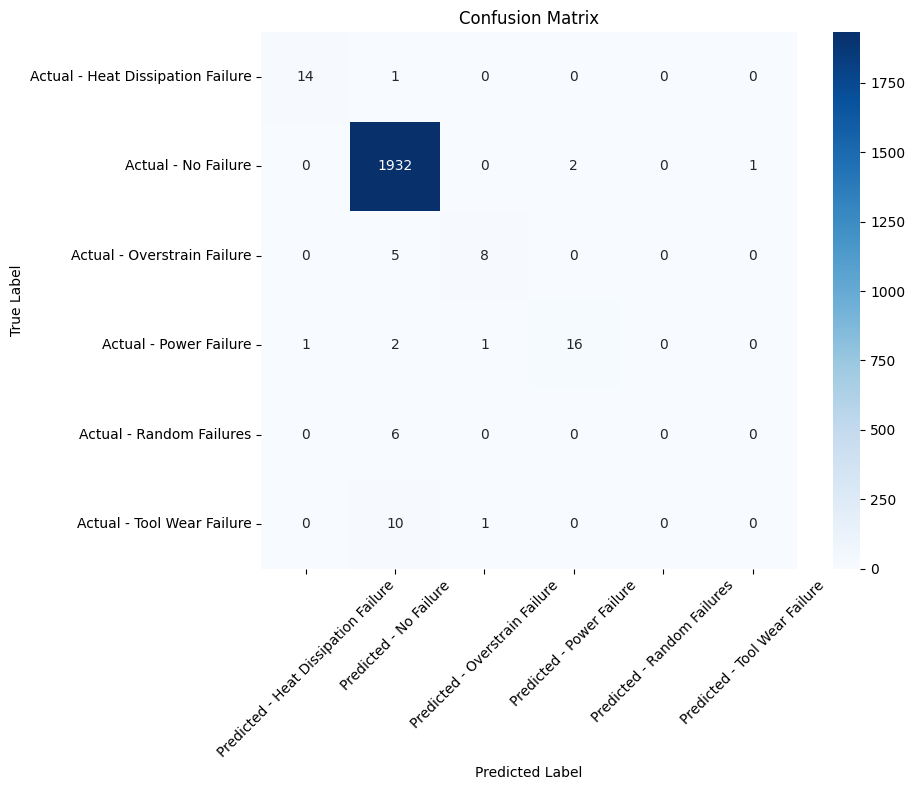

In [9]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(
    cm, 
    index=[f"Actual - {label}" for label in label_encoder.classes_], 
    columns=[f"Predicted - {label}" for label in label_encoder.classes_]
)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [20]:
# evaluate metrics on test data
gradient_boosting_best_model_performance_test = model_performance_classification(
    gradient_boosting_best_model, X_test, y_test
)
gradient_boosting_best_model_performance_test

C:\Users\Zahra\Desktop\ProjectBigDataAnalytics\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Recall,Precision,F1
0,0.985,0.985,0.976718,0.980729


# Multiclassification en utilisant le modèle Random Forest avec Randomized Search CV pour trouver les meilleurs hyperparamètres

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE  # Import SMOTE
from scipy.stats import randint

# Load the dataset
machines_data = pd.read_csv('predictive_maintenance.csv')

# Define features and target
num_features = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
cat_features = ["Type"]
target_variable = 'Failure Type'  # The target for multiclass classification
not_imp_variables = ['UDI', 'Product ID', 'Target']

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Split the data into training and testing sets
train_df, test_df = train_test_split(machines_data, test_size=0.2, random_state=42)

# Separate input features and target variable
input_features_train_df = train_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_train_df = train_df[target_variable]

input_features_test_df = test_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_test_df = test_df[target_variable]

# Encode the target variable ('Failure Type') into integers using LabelEncoder
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train_df)
target_test_encoded = label_encoder.transform(target_test_df)

# Preprocess the input features
input_features_train_df_array = preprocessor.fit_transform(input_features_train_df)
input_features_test_df_array = preprocessor.transform(input_features_test_df)

# Combine input features and target variable into arrays
train_array = np.c_[input_features_train_df_array, target_train_encoded]
test_array = np.c_[input_features_test_df_array, target_test_encoded]

# Define X and y for training and testing
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

# # Step 1: Apply SMOTE to oversample the minority classes in the training set
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# print(f"Original training dataset shape: {np.bincount(y_train.astype(int))}")
# print(f"Resampled training dataset shape: {np.bincount(y_train_resampled.astype(int))}")

# Step 2: Initialize the Random Forest Classifier
base_model = RandomForestClassifier(random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),            # Number of trees in the forest
    'max_depth': [10, 20, 30, 40, 50],     # Depth of each tree
    'min_samples_split': randint(2, 20),         # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10)         # Minimum samples required at a leaf node
}

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1_weighted',  # Evaluation metric (weighted F1-score for multiclass)
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Step 4: Perform RandomizedSearchCV on the resampled data
random_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
print("Best F1-Weighted Score from RandomizedSearchCV:", random_search.best_score_)

# Step 5: Use the best model to make predictions
best_model = random_search.best_estimator_

# Train the best model on the resampled training set
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from RandomizedSearchCV: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 196}
Best F1-Weighted Score from RandomizedSearchCV: 0.9749938912996317


RandomForestClassifier(max_depth=50, n_estimators=196, random_state=42)

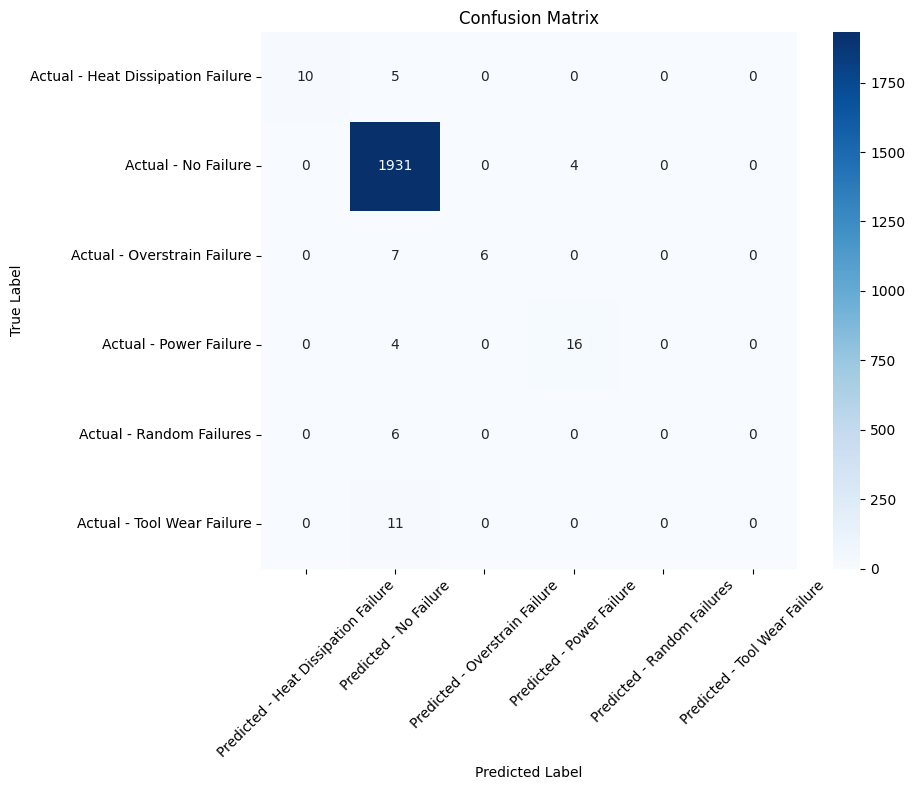

In [2]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(
    cm, 
    index=[f"Actual - {label}" for label in label_encoder.classes_], 
    columns=[f"Predicted - {label}" for label in label_encoder.classes_]
)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Step 6: Evaluate the final model
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score for multiclass
print(f"Final F1 Score on Test Set (Weighted): {f1}")

# Generate the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final F1 Score on Test Set (Weighted): 0.9764240628501235
Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.67      0.80        15
              No Failure       0.98      1.00      0.99      1935
      Overstrain Failure       1.00      0.46      0.63        13
           Power Failure       0.80      0.80      0.80        20
         Random Failures       1.00      0.00      0.00         6
       Tool Wear Failure       1.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.96      0.49      0.54      2000
            weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[  10    5    0    0    0    0]
 [   0 1931    0    4    0    0]
 [   0    7    6    0    0    0]
 [   0    4    0   16    0    0]
 [   0    6    0    0    0    0]
 [   0   11    0    0    0    0]]


In [18]:
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
)
import pandas as pd

def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance for multiclass classification.

    model: classifier
    predictors: independent variables (features)
    target: dependent variable (labels)
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    # Compute metrics
    acc = accuracy_score(target, pred)  # Compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # Weighted Recall
    precision = precision_score(target, pred, average='weighted')  # Weighted Precision
    f1 = f1_score(target, pred, average='weighted')  # Weighted F1-score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": [acc], "Recall": [recall], "Precision": [precision], "F1": [f1]}
    )

    return df_perf


# random forest avec les meilleurs hyperparameters

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Load the dataset
machines_data = pd.read_csv('predictive_maintenance.csv')

# Define features and target
num_features = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
cat_features = ["Type"]
target_variable = 'Failure Type'  # The new target for multiclass classification
not_imp_variables = ['UDI', 'Product ID','Target']

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Split the data into training and testing sets
train_df, test_df = train_test_split(machines_data, test_size=0.2, random_state=42)

# Separate input features and target variable
input_features_train_df = train_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_train_df = train_df[target_variable]

input_features_test_df = test_df.drop(columns=[target_variable] + not_imp_variables, axis=1)
target_test_df = test_df[target_variable]

# Encode the target variable ('Failure Type') into integers using LabelEncoder
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train_df)
target_test_encoded = label_encoder.transform(target_test_df)

# Preprocess the input features
input_features_train_df_array = preprocessor.fit_transform(input_features_train_df)
input_features_test_df_array = preprocessor.transform(input_features_test_df)

# Combine input features and target variable into arrays
train_array = np.c_[input_features_train_df_array, target_train_encoded]
test_array = np.c_[input_features_test_df_array, target_test_encoded]

# Define X and y for training and testing
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

# Initialize the Random Forest Classifier with tuned hyperparameters
random_forest_best_model = RandomForestClassifier(
    n_estimators=196,        # Number of trees
    max_depth=50,            # Maximum depth of each tree
    min_samples_split=2,     # Minimum samples required to split a node
    min_samples_leaf=1,      # Minimum samples required at a leaf node
    random_state=42          # Random seed for reproducibility
)

# Train the model on the training set
random_forest_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_best_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score for multiclass
print(f"F1 Score on Test Set (Weighted): {f1}")

# Additional evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

F1 Score on Test Set (Weighted): 0.9764240628501235
Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.67      0.80        15
              No Failure       0.98      1.00      0.99      1935
      Overstrain Failure       1.00      0.46      0.63        13
           Power Failure       0.80      0.80      0.80        20
         Random Failures       1.00      0.00      0.00         6
       Tool Wear Failure       1.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.96      0.49      0.54      2000
            weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[  10    5    0    0    0    0]
 [   0 1931    0    4    0    0]
 [   0    7    6    0    0    0]
 [   0    4    0   16    0    0]
 [   0    6    0    0    0    0]
 [   0   11    0    0    0    0]]


In [7]:
import joblib

# Save the Gradient Boosting model
joblib.dump(random_forest_best_model, "random_forest_best_model.pkl")
print("Model, LabelEncoder, and Preprocessor saved successfully.")


Model, LabelEncoder, and Preprocessor saved successfully.


In [19]:
# evaluate metrics on test data
random_forest_best_model_performance_test = model_performance_classification(
    random_forest_best_model, X_test, y_test
)
random_forest_best_model_performance_test

C:\Users\Zahra\Desktop\ProjectBigDataAnalytics\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Recall,Precision,F1
0,0.9815,0.9815,0.973244,0.976424


In [21]:
final_model_names = ['gradient_boosting_best_model_performance_test', 'random_forest_best_model_performance_test']
dataframes_2 = [gradient_boosting_best_model_performance_test, random_forest_best_model_performance_test]

for df2, name in zip(dataframes_2, final_model_names):
    df2['Model'] = name
    
# Concatenate DataFrames
combined_df_final2 = pd.concat(dataframes_2, ignore_index=True)

combined_df_final2

,Accuracy,Recall,Precision,F1,Model
0,0.9850,0.9850,0.976718,0.980729,gradient_boosting_best_model_performance_test
1,0.9815,0.9815,0.973244,0.976424,random_forest_best_model_performance_test
